In [65]:
import uns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

training = pd.read_msgpack('training.bin')
training.columns

Index(['Cc', 'Cr', 'H', 'S0', 'S1', 'V0', 'V1', 'W', 'img', 'lenskel',
       'maxdist', 'meandist', 'medidist', 'moments', 'npixels', 'pixels',
       'subject', 'xmax', 'xmin', 'ymax', 'ymin', 'hasmask'],
      dtype='object')

# Prepare the numeric array

In [227]:
data = training[training['hasmask']][['H', 'S0', 'S1', 'W', 'lenskel', 'maxdist', 'meandist', 'medidist', 'npixels']].values

In [228]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
X = StandardScaler().fit_transform(data)
P = pca.fit(X)
pca.explained_variance_ratio_

array([ 0.55935244,  0.25799109,  0.08758853,  0.07611075,  0.01125477])

In [229]:
P.fit_transform(X)

array([[-3.21256267, -0.40249489,  0.85124991,  0.08436339, -0.13655746],
       [-0.67123295, -1.11104281, -0.18875747, -0.27408442,  0.01115162],
       [ 1.65423901, -1.17972734,  0.60650793, -0.41660468,  0.15337924],
       ..., 
       [-0.54481404, -0.1152629 ,  0.13899016,  1.57318295,  0.02224082],
       [-2.16334844,  2.01804337, -0.46549502,  2.11386492,  0.21534176],
       [ 0.36883234, -0.20541203, -0.143467  ,  1.43235512, -0.58161622]])

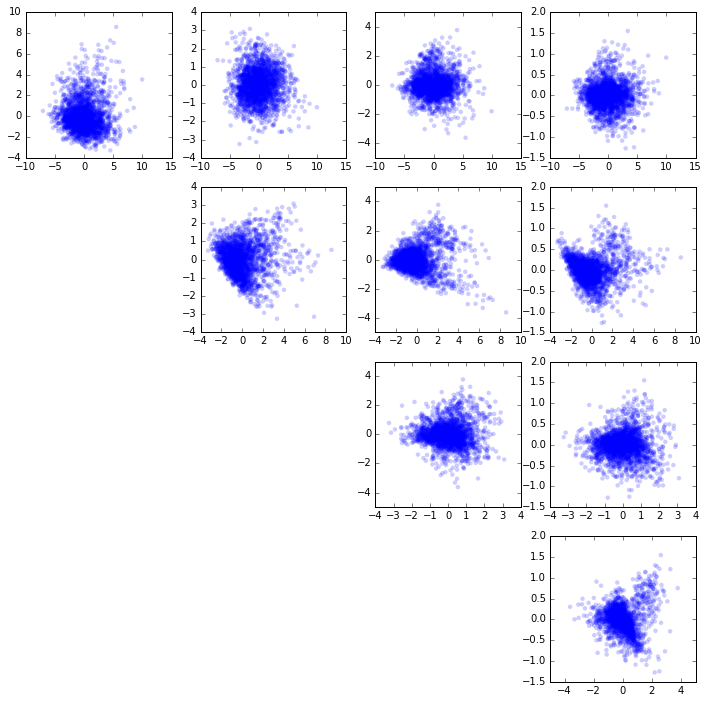

In [230]:
def plot_pca_comps(P, ncomp, *args, **kwargs):
    fig = plt.figure(figsize=kwargs.pop('figsize',(8,6)))
    for i in np.arange(ncomp):        
        for j in np.arange(i+1, ncomp):
            ax = fig.add_subplot(ncomp-1, ncomp-1, j+i*(ncomp-1))
            ax.scatter(P[:,i], P[:,j], *args, **kwargs)

plot_pca_comps(P.fit_transform(X), 5, figsize=(12,12), alpha=0.2, edgecolors='none')

## Clustering

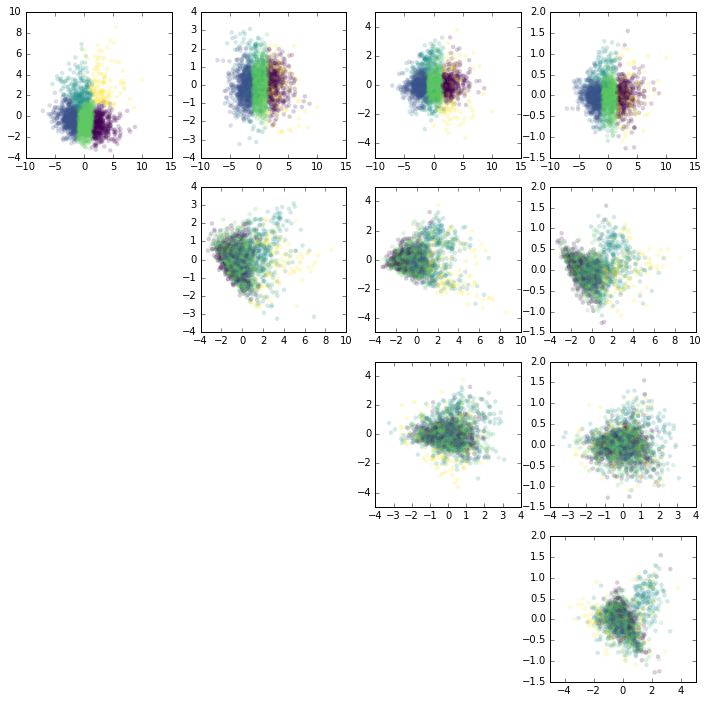

In [242]:
from sklearn import cluster
kmc = cluster.KMeans(n_clusters=5).fit_predict(P.transform(X))

plot_pca_comps(P.fit_transform(X), 5, figsize=(12,12), 
               alpha=0.2, 
               edgecolors='none', 
               color=kmc, 
               cmap=plt.cm.viridis)

0.0


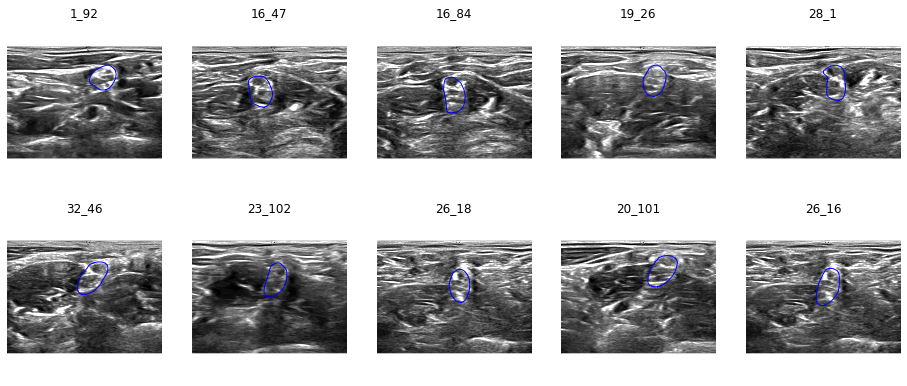

1.0


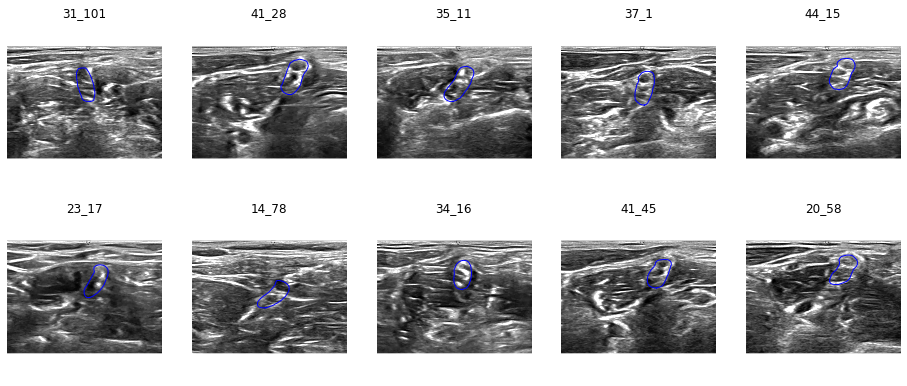

2.0


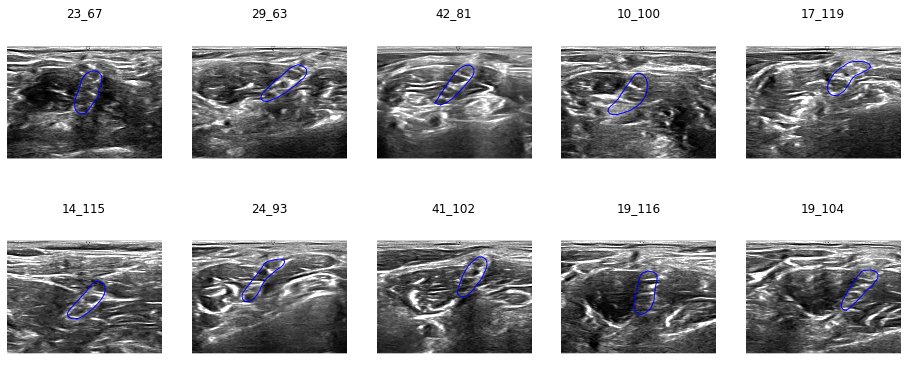

3.0


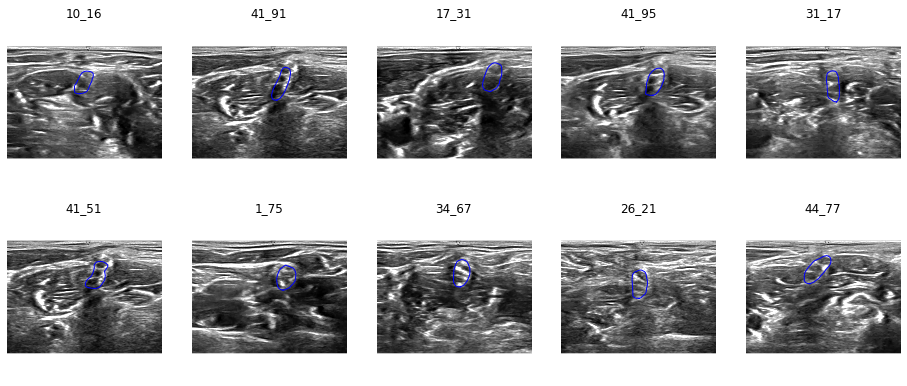

4.0


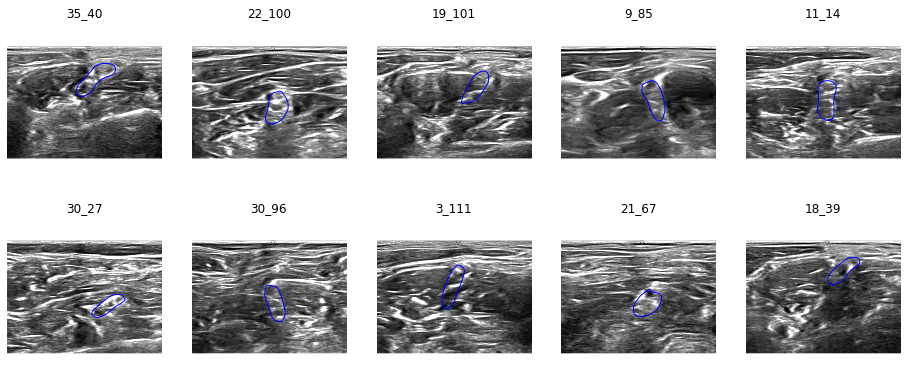

In [240]:
training.loc[training['hasmask'],'KMeansCluster'] = kmc

clusters = training.groupby(by='KMeansCluster')

for key, group in clusters:
    batch = uns.batch(group.sample(n=np.min((10,len(group)))))
    print(key)
    ax = batch.plot_grid()
    plt.show()

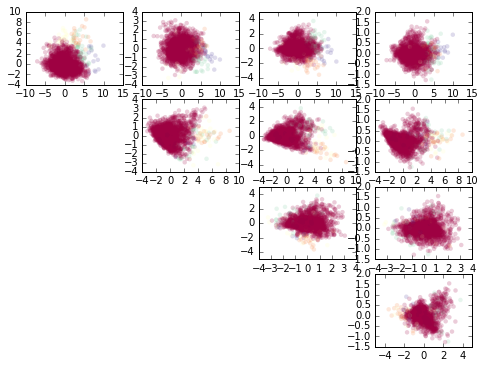

In [243]:
bandwidth = cluster.estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(P.transform(X))
labels = ms.labels_

plot_pca_comps(P.fit_transform(X), 5, 
               alpha=0.2, 
               edgecolors='none', 
               color=ms.labels_, 
               cmap=plt.cm.Spectral)

# Examples from groups identified

0.0


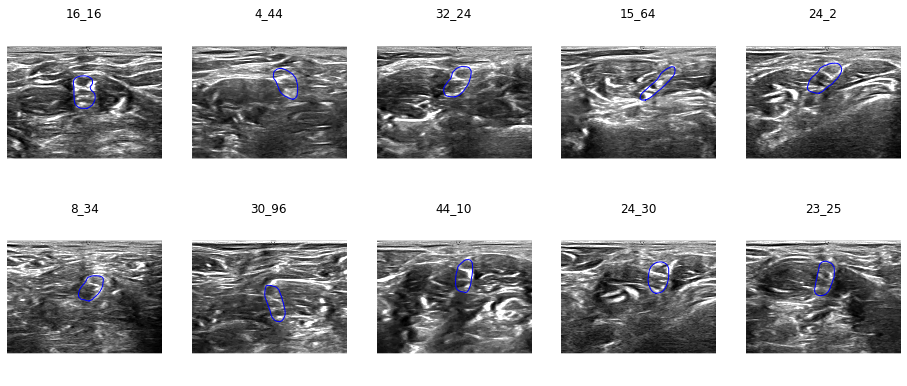

1.0


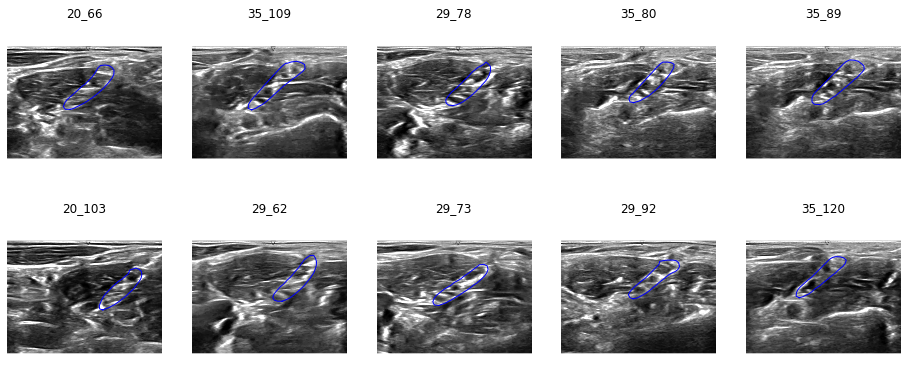

2.0


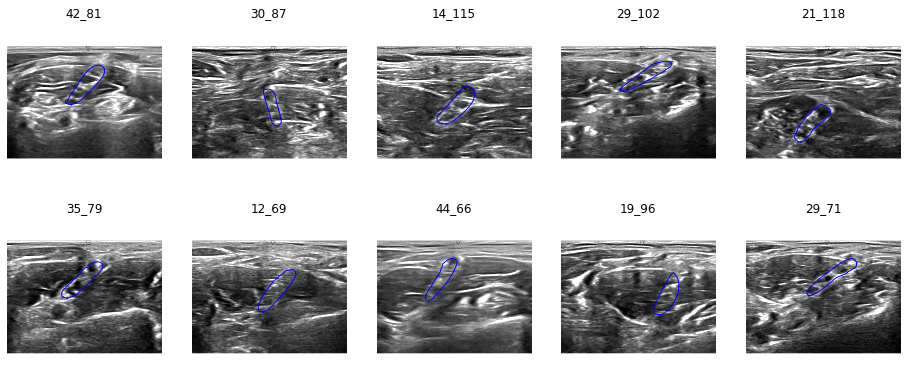

3.0


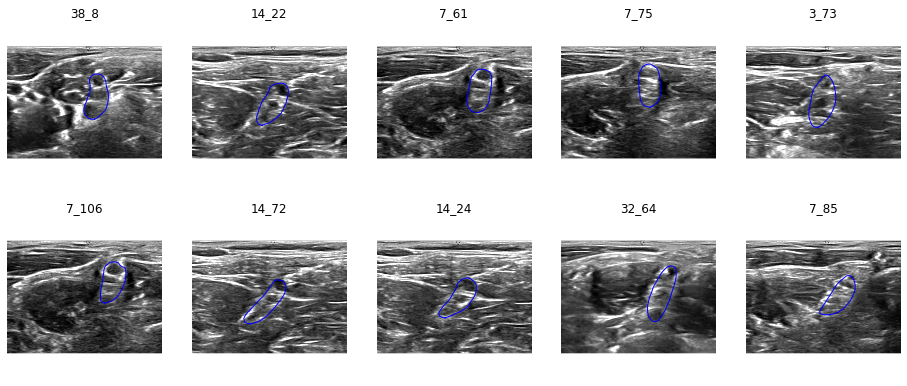

4.0


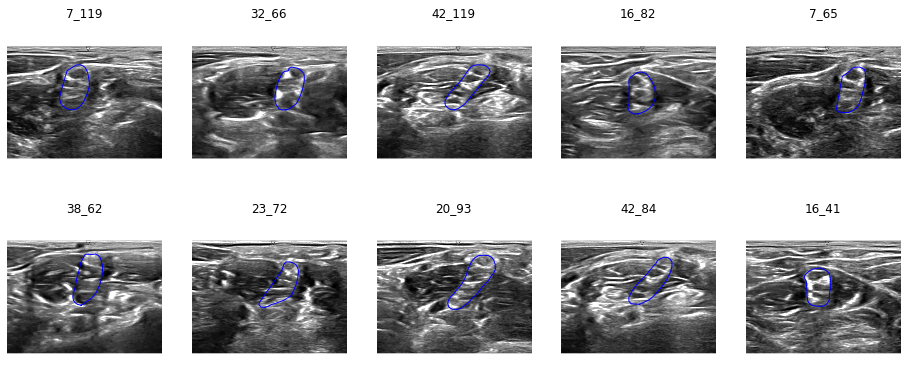

In [244]:
training.loc[training['hasmask'],'MeanShiftCluster'] = ms.labels_

clusters = training.groupby(by='MeanShiftCluster')

for key, group in clusters:
    batch = uns.batch(group.sample(n=np.min((10,len(group)))))
    print(key)
    ax = batch.plot_grid()
    plt.show()

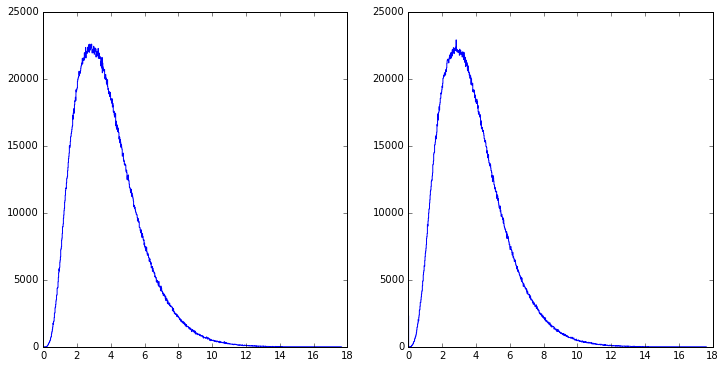

In [254]:
from sklearn import metrics
DX = metrics.pairwise_distances(X)
DPX = metrics.pairwise_distances(P.transform(X))
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(DX.flatten(), bins=1000, histtype='step')
ax[1].hist(DPX.flatten(),bins=1000, histtype='step')
plt.show()

Found 20 clusters


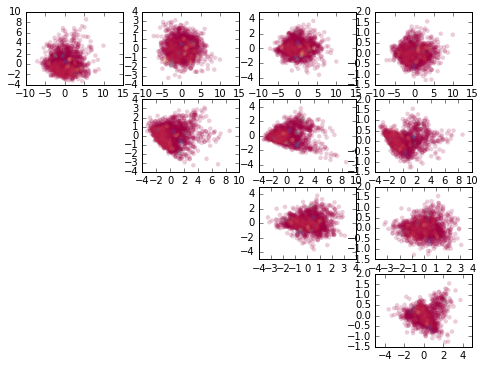

In [264]:
db = cluster.DBSCAN(eps=.5, min_samples=5)
db.fit(P.transform(X))
labels = db.labels_
print('Found {:d} clusters'.format(len(set(labels))))
plot_pca_comps(P.fit_transform(X), 5, 
               alpha=0.2, 
               edgecolors='none', 
               color=labels,
               cmap=plt.cm.Spectral)

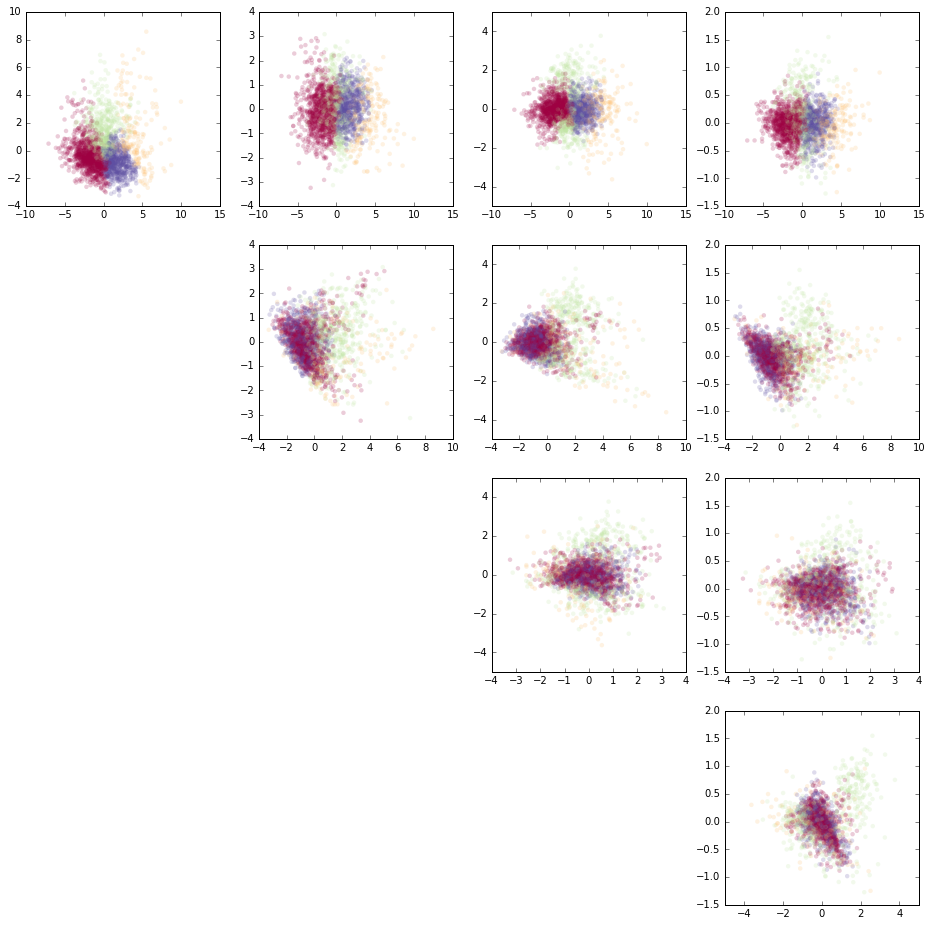

In [265]:
ac = cluster.AgglomerativeClustering(n_clusters=4)
ac.fit(P.transform(X))
labels = ac.labels_

plot_pca_comps(P.fit_transform(X), 5, figsize=(16,16),
               alpha=0.2, 
               edgecolors='none', 
               color=labels,
               cmap=plt.cm.Spectral)

0.0


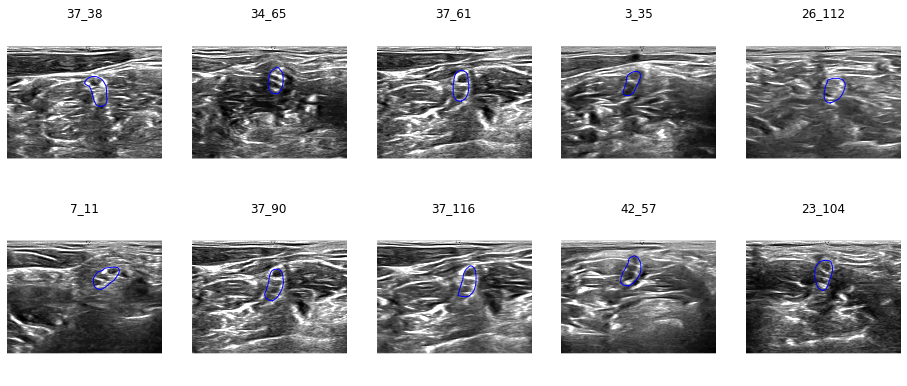

1.0


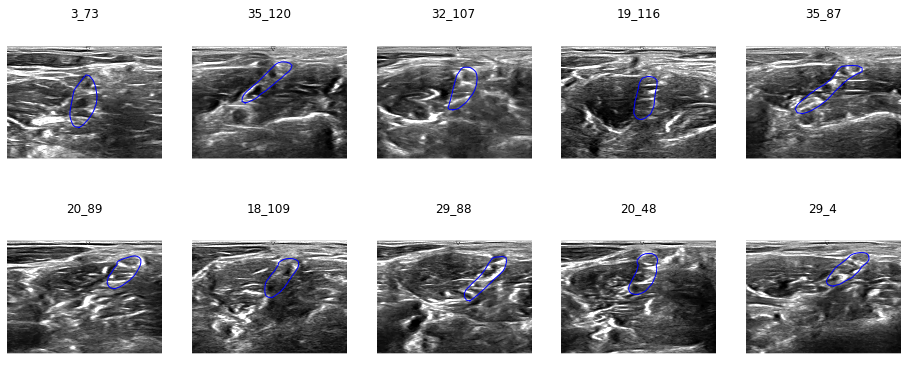

2.0


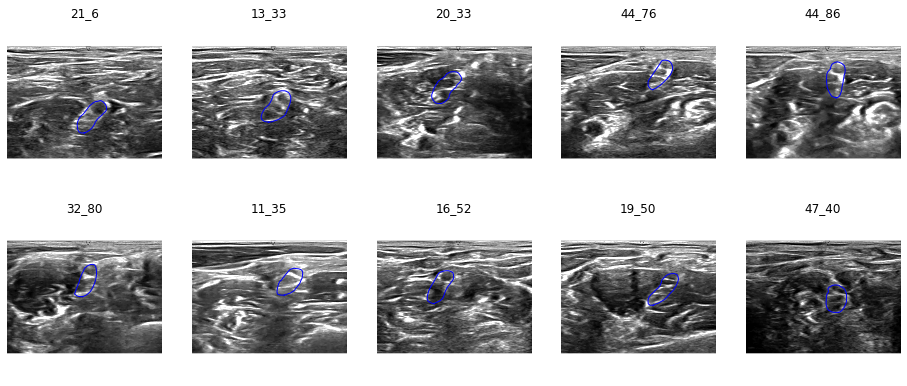

3.0


/Users/chrisv/anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


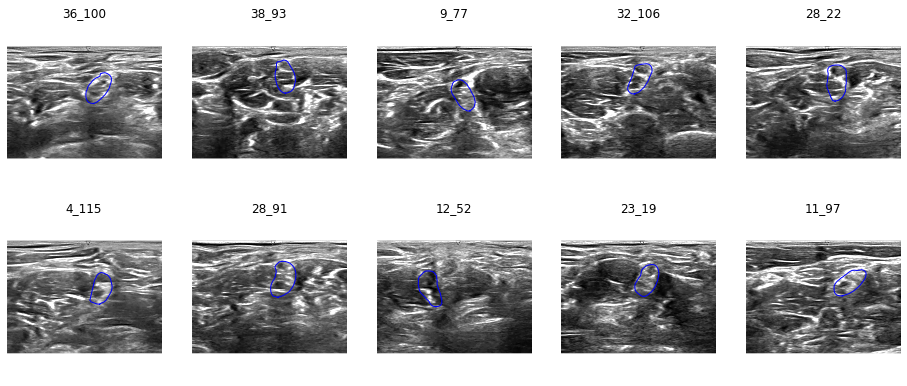

In [266]:
training.loc[training['hasmask'],'AggCluster'] = ac.labels_

clusters = training.groupby(by='AggCluster')

for key, group in clusters:
    batch = uns.batch(group.sample(n=np.min((10,len(group)))))
    print(key)
    ax = batch.plot_grid()
    plt.show()